In [144]:
import os, sys
import re
import random
import numpy as np
import scipy as sc
import pickle as pkl
import matplotlib.pyplot as plt
import tqdm
import pickle as pkl
import json

from pathlib import Path
import IPython
import librosa
from librosa import display
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, metrics

from itertools import product
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz

from IPython.display import Image
sys.path.insert(0, os.path.join("..", "src"))
from MultiClassSVM import *
from OneVsAllClassifier import *
from DecisionTree import *
from GradientBoosting import *
from utils import pseudo_residual_L2, pseudo_residual_logistic

%matplotlib inline

In [145]:
json.dump?

Signature:
json.dump(
    obj,
    fp,
    *,
    skipkeys=False,
    ensure_ascii=True,
    check_circular=True,
    allow_nan=True,
    cls=None,
    indent=None,
    separators=None,
    default=None,
    sort_keys=False,
    **kw,
)
Docstring:
Serialize ``obj`` as a JSON formatted stream to ``fp`` (a
``.write()``-supporting file-like object).

If ``skipkeys`` is true then ``dict`` keys that are not basic types
(``str``, ``int``, ``float``, ``bool``, ``None``) will be skipped
instead of raising a ``TypeError``.

If ``ensure_ascii`` is false, then the strings written to ``fp`` can
contain non-ASCII characters if they appear in strings contained in
``obj``. Otherwise, all such characters are escaped in JSON strings.

If ``check_circular`` is false, then the circular reference check
for container types will be skipped and a circular reference will
result in an ``OverflowError`` (or worse).

If ``allow_nan`` is false, then it will be a ``ValueError`` to
serialize out of range ``float`` 

# Problem 1

The hinge loss penalty is defined as 
$$\ell_1(h, (x_i,y_i)) = \max_{y\in \mathcal{Y}\backslash \{y_i\}}\left(\Delta(y_i,y)-m_{i,y}(h)\right)_+ $$
while the generalized hinge loss is defined as 
$$\ell_2(h, (x_i,y_i)) = \max_{y\in \mathcal{Y}}\left[\Delta(y_i,y)+h(x_i,y)-h(x_i,y_i)\right]$$

## 1.1

Supposing $\Delta(y,y) = 0$ then 
\begin{align*}
\ell_2(h, (x_i,y_i)) &= \max_{y\in \mathcal{Y}}\left[\Delta(y_i,y)+h(x_i,y)-h(x_i,y_i)\right]\\
&= \max \left(\Delta(y_i,y_i) + h(x_i,y_i) - h(x_i,y_i), \max_{y\in \mathcal{Y}\backslash\{y_i\}}\left[\Delta(y_i,y)+h(x_i,y)-h(x_i,y_i)\right]\right)\\
&= \max \left(0, \max_{y\in \mathcal{Y}\backslash\{y_i\}}\left[\Delta(y_i,y)+h(x_i,y)-h(x_i,y_i)\right]\right)\\
&= \max \left(0, \max_{y\in \mathcal{Y}\backslash\{y_i\}}\left[\Delta(y_i,y)-m_{i,y}(h)\right]\right)\\
&= \max_{y\in \mathcal{Y}\backslash\{y_i\}}\left[\Delta(y_i,y)-m_{i,y}(h)\right]_+\\
\end{align*}

## 1.2

Supposing $m_{i,y}(h) = h(x_i,y_i)-h(x_i,y) \ge \Delta(y_i,y)$ then $\Delta(y_i,y) -m_{i,y}(h) \le 0$ which implies $\ell_1(h,(x_i,y_i))=0$. This further implies $\ell_1(h,(x_i,y_i))=0$

Under the above conditions, since $h(x_i,y_i)-h(x_i,y)\gt 0$ then $h(x_i,y_i)\gt h(x_i,y)$ we must have that $y_i = \arg \max h(x_i,y)$ which means we make a correct prediction.

# Problem 2

The $\ell_2$ regularized loss function is given by 
$$J(w) = \lambda \|w\|^2 + \frac{1}{n} \sum_{i=1}^n \max_{y\in \mathcal{Y}}\left[\Delta(y_i,y) + \langle w, \Psi(x_i,y)-\Psi(x_i,y_i)\rangle\right]$$

## Problem 2.1

The function $J(w)$ is convex since the first term is the sum of squares and the second terms is the pointwise maximum of an affine function of $w$. Since affine functions are convex, the pointwise maximum of convex functions is convex, and the sum of convex functions is convex, then $J(w)$ is convex.

## Problem 2.2

A subgradient of $J(w)$ is given by 
$$2\lambda w + 1/n\sum_{i=1}^n \Psi(x_i,\hat{y}_i) - \Psi(x_i,y_i)$$ where $\hat{y}_i = \arg \max_{y\in \mathcal{Y}}\left[\Delta(y_i,y) + \langle w, \Psi(x_i,y)-\Psi(x_i,y_i)\rangle\right]$

# Problem 3

Given $\mathcal{Y} = \{-1,1\}$ and $\Delta(y,\hat{y})=\mathbf{1}(y\ne\hat{y})$ as well as the compatibility score functions $h(x,1) = g(x)/2$ and $h(x,-1)=-g(x)/2$ the multiclass hinge loss is given by 

\begin{align*}
\ell(h,(x,y)) &= \max_{y'\in\mathcal{Y}}\left[\Delta(y,y') + h(x,y')-h(x,y)\right]\\
&= \max\left(\Delta(y,-1) + h(x,-1)-h(x,y), \Delta(y,1) + h(x,1)-h(x,y)\right)\\
&= \max\left(\Delta(y,-1) -g(x)/2-yg(x)/2, \Delta(y,1) + g(x)/2-yg(x)/2\right)\\
&= \max\left\{0,1-yg(x)\right\}\\
\end{align*}


# Problem 4

## 4.1

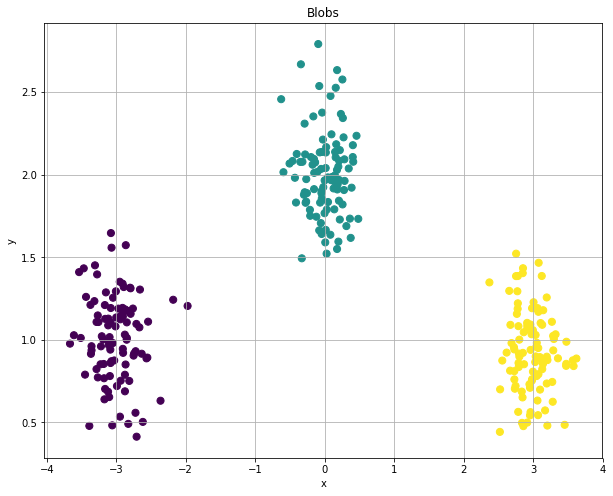

In [2]:
# Create the  training data
np.random.seed(2)
X, y = make_blobs(
    n_samples=300,
    cluster_std=.25,
    centers=np.array([(-3,1),(0,2),(3,1)])
)

plt.figure(figsize=(10,8));
plt.scatter(X[:, 0], X[:, 1], c=y, s=50);
plt.grid(True);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Blobs");

/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Coeffs 0
[[-1.05852747 -0.90296521]]
Coeffs 1
[[ 0.22117096 -0.38900908]]
Coeffs 2
[[ 0.89162796 -0.82467394]]


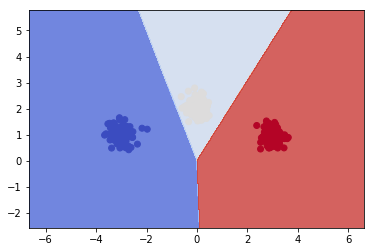

In [24]:
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=200)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X, y)

for i in range(3) :
    print(f"Coeffs {i}")
    print(clf_onevsall.estimators[i].coef_)

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0]) - 3, max(X[:,0]) + 3
y_min, y_max = min(X[:,1]) - 3, max(X[:,1]) + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm);

In [26]:
metrics.confusion_matrix(y, clf_onevsall.predict(X))

array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

## 4.2

w: [-5.14748980e-10  3.01805016e-12 -2.00932911e-10  3.29705584e-10
  7.15681891e-10 -3.32723634e-10]


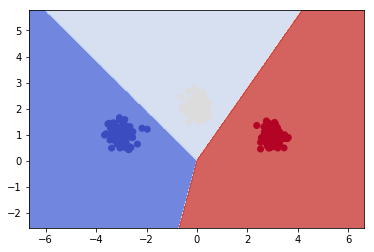

In [27]:
est = MulticlassSVM(6, lam=1)
est.fit(X, y, epochs=2000)
print(f"w: {est.coef_}")
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8);

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm);

In [28]:
metrics.confusion_matrix(y, est.predict(X))

array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

# Problem 5

In [2]:
audio_folder = Path("..", "data", "UrbanSound8K", "audio")
class_dirs = os.listdir(audio_folder)

class_to_file = {}
for d in class_dirs:
    match = re.search("^fold([0-9]+)", d)
    if not match:
        continue
    candidate_files = os.listdir(audio_folder / d)
    rand_sound_file = random.choice(candidate_files)
    if rand_sound_file is not None:
        label = int(match.groups()[0])
        class_to_file[label] = (audio_folder / d /rand_sound_file).absolute()

In [3]:
X = {}
for key, val in class_to_file.items():
    signal, fs = librosa.load(val)
    X[key] = signal

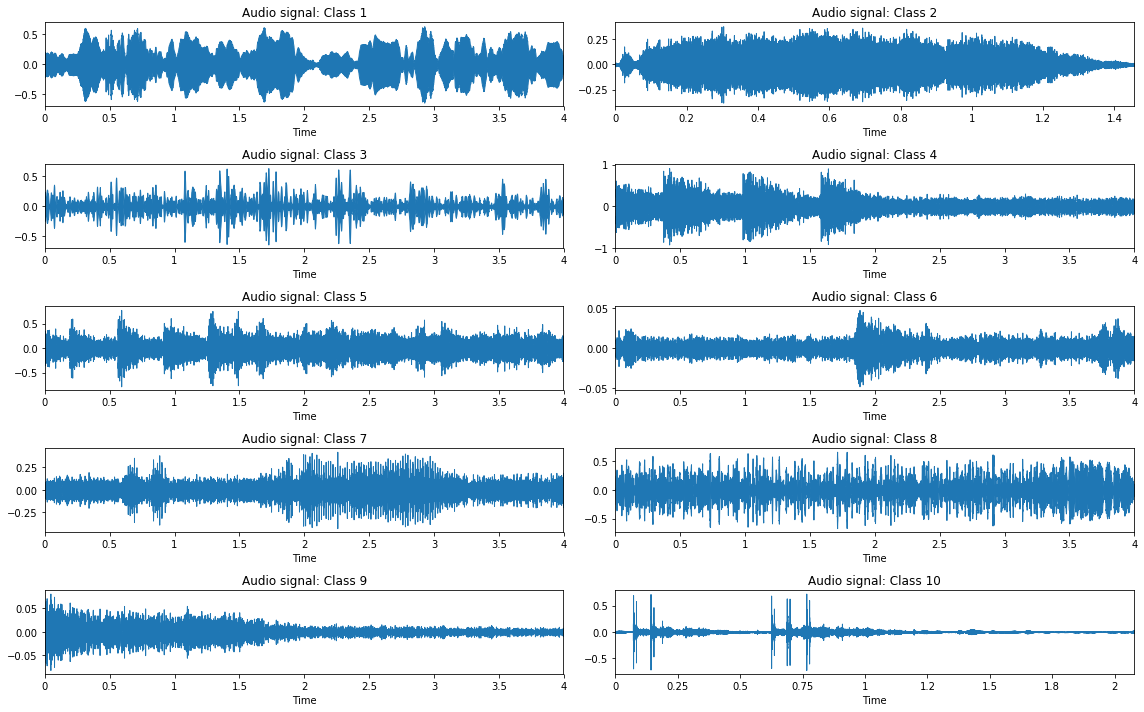

In [4]:
plt.figure(figsize=(16,10))

for i in range(1,11):
    plt.subplot(5, 2, i)
    display.waveplot(X[i], sr=fs);
    plt.title(f"Audio signal: Class {i}");
plt.tight_layout()

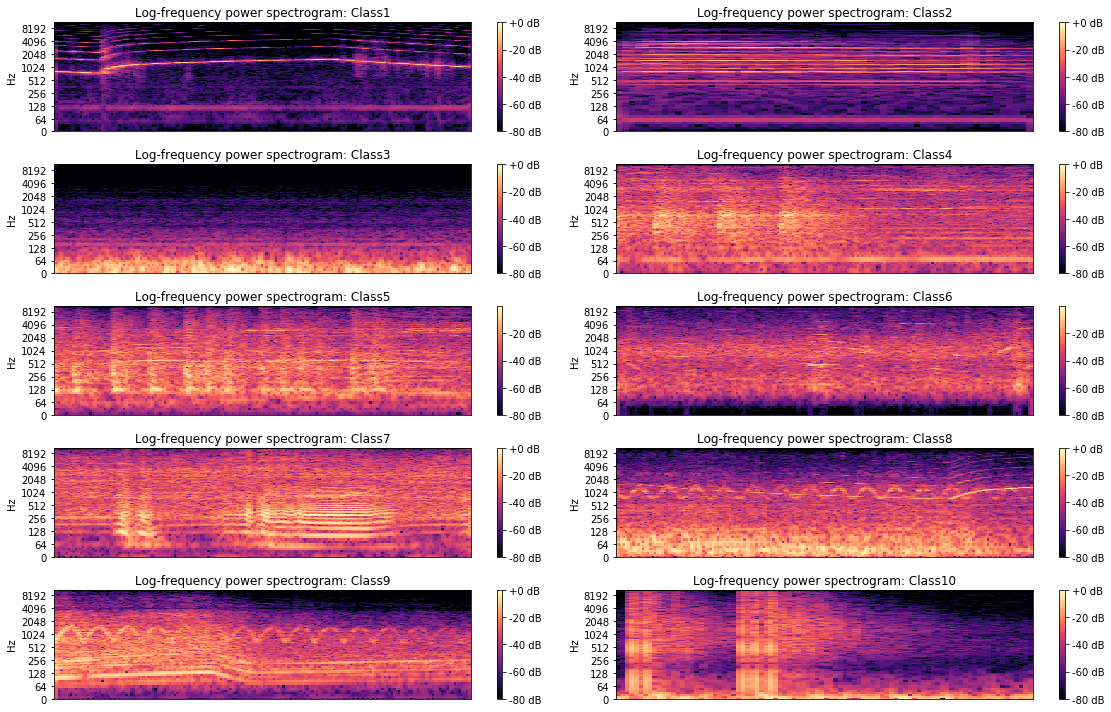

In [5]:
plt.figure(figsize=(16,10))

for i in range(1, 11):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(X[i])), ref=np.max)
    plt.subplot(5, 2, i)
    display.specshow(D, y_axis="log");
    plt.colorbar(format="%+2.0f dB");
    plt.title(f"Log-frequency power spectrogram: Class{i}");
plt.tight_layout()

In [6]:
IPython.display.Audio(X[5], rate=fs)

In [7]:
IPython.display.Audio(X[8], rate=fs)

In [25]:
data_folder = Path("..", "data", "UrbanSound8K", "audio")

try:
    with open(data_folder / "raw_sound_data.pkl", "rb") as f:
        X_data = pkl.load(f)
        fs = 22050
except:
    X_data = []
    for i in range(1,11):
        class_folder = data_folder / f"fold{i}"
        class_files = os.listdir(class_folder)
        class_data = []
        for fname in tqdm.tqdm(class_files):
            try:
                _, ext = os.path.splitext(fname)
                if ext != ".wav":
                    continue
                signal, fs = librosa.load(class_folder / fname)
                class_data.append(signal)
            except: 
                print(f"Unable to load {fname}")
        X_data.append(class_data)
    with open(data_folder / "raw_sound_data.pkl", "wb") as f:
        pkl.dump(X_data, f)


## Signal EDA

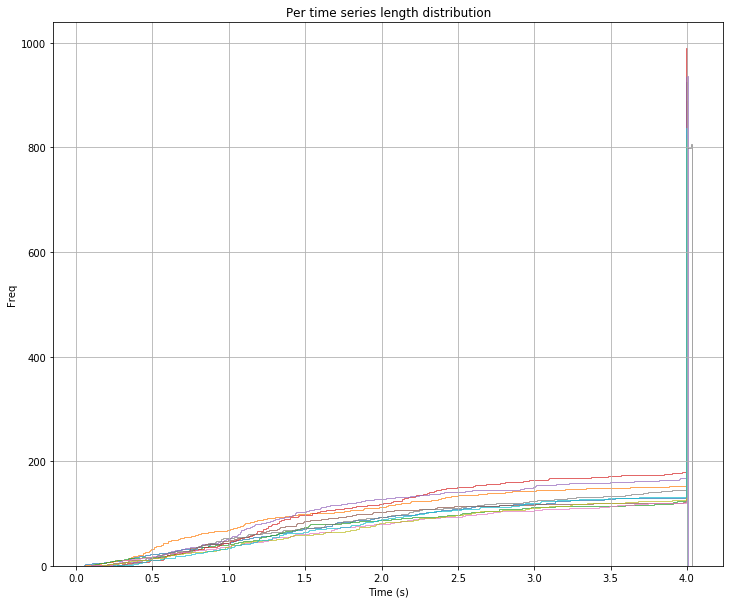

In [26]:
plt.figure(figsize=(12, 10))

for i, class_data in enumerate(X_data):
    signal_lengths = np.array([signal.size /fs for signal in class_data])
    plt.hist(signal_lengths, cumulative=True, bins=500, histtype="step", alpha=0.7);
    plt.grid(True, which="both");
plt.title("Per time series length distribution")
plt.xlabel("Time (s)");
plt.ylabel("Freq");


## Train-Test Split

In [92]:
X_list, y_list = [], []

for i in range(10):
    X_list += X_data[i]
    y_list += ([i + 1] * len(X_data[i]))

X_train, X_test, y_train, y_test = train_test_split(X_list, y_list, test_size=0.3, random_state=45)

print(f"X_train: {len(X_train)}, y_train: {len(y_train)}")
print(f"X_test: {len(X_test)}, y_test: {len(y_test)}")

X_train: 6112, y_train: 6112
X_test: 2620, y_test: 2620


## Featurize

In [96]:
n_sample_augment = 10

X_feat_train = []
y_feat_train = []

for i, (x, y) in enumerate(zip(X_train, y_train)):
    try:
        mfcc_feats = librosa.feature.mfcc(x, n_mfcc=15) # 15 x n_windows
        mfcc_first_diff = librosa.feature.delta(mfcc_feats, order=1)
        mfcc_second_diff = librosa.feature.delta(mfcc_feats, order=2)
    except:
        print(f"Skipping ({i},{y})", flush=True)
    else:
        _, n_samples = mfcc_feats.shape
        feats = np.concatenate([mfcc_feats, mfcc_first_diff, mfcc_second_diff], axis=0).T
        rand_indices = np.random.permutation(n_samples)[:n_sample_augment] # downsample the training data
        X_feat_train.append(feats[rand_indices, :])
        y_feat_train.append([y + 1] * rand_indices.size)
        cnt += n_samples
#     print(f"Processed {cnt} examples for class {i + 1}", flush=True)

Skipping (454,5)
Skipping (477,6)
Skipping (501,2)
Skipping (659,3)
Skipping (1106,1)
Skipping (1597,1)
Skipping (1763,2)
Skipping (2426,7)
Skipping (3872,9)
Skipping (3881,2)
Skipping (4338,1)
Skipping (4448,3)
Skipping (5587,1)
Skipping (5831,1)
Skipping (5890,3)
Skipping (6078,3)


In [97]:
X_feat_train = np.concatenate(X_feat_train, axis=0)
y_feat_train = np.concatenate(y_feat_train)

print(f"X_feat_train: {X_feat_train.shape}, y_feat_train: {y_feat_train.shape}")

X_feat_train: (60956, 45), y_feat_train: (60956,)


In [98]:
preprocessor = MinMaxScaler()
X_train_normalized = preprocessor.fit_transform(X_feat_train)

In [99]:
parameters = {
    "kernel": ["rbf"], 
    "C": 10.0**np.array([0.5, 1, 1.1, 1.2]),
    "gamma": 10.0**np.array([1.1, 1.2]),
}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=2, n_jobs=-1, verbose=True)

In [100]:
clf.fit(X_train_normalized, y_feat_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 587.5min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'kernel': ['rbf'], 'C': array([ 3.16228, 10.     , 12.58925, 15.84893]), 'gamma': array([12.58925, 15.84893])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [149]:
with open("urban_sound_classifier.pkl", "wb") as f:
    pkl.dump(clf.best_estimator_, f)

with open("urban_sound_classifier_cv_results.pkl", "wb") as f:
    pkl.dump(clf.cv_results_, f)

In [165]:
print(f"Best cross validation score: {clf.best_score_}",flush=True)
print(f"Best cross validation params: {json.dumps(clf.best_params_, indent=4)}", flush=True)

Best cross validation score: 0.5759728328630488
Best cross validation params: {
    "C": 3.1622776601683795,
    "gamma": 15.848931924611133,
    "kernel": "rbf"
}


In [103]:
clf.cv_results_

/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.wa

{'mean_fit_time': array([  196.96364868,   201.30618441,   192.67716002,   194.07773387,
          192.44767606,   187.56908   , 34070.87061906, 34069.28018856]),
 'std_fit_time': array([7.06637442, 3.22005355, 6.92656302, 5.90051615, 4.22147119,
        2.70145309, 8.97848678, 5.72805643]),
 'mean_score_time': array([73.796471  , 76.0721271 , 75.62359035, 74.68154836, 69.54322243,
        70.4583745 , 73.49815297, 76.10085392]),
 'std_score_time': array([2.91843212, 1.51138711, 0.10217559, 0.12282848, 1.06632638,
        0.82080245, 3.17709112, 0.40903473]),
 'param_C': masked_array(data=[3.1622776601683795, 3.1622776601683795, 10.0, 10.0,
                    12.589254117941675, 12.589254117941675,
                    15.848931924611133, 15.848931924611133],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[12.589254117941675, 15.848931924611133,
                    12.589

### Test

In [124]:
from scipy.stats import mode
from sklearn.metrics import confusion_matrix

def compute_predictions(X):
    for i, x_test in enumerate(X):
        if i > 0 and i % 50 == 0:
            print(f"Test Example: {i}", flush=True)
        try:
            mfcc_feats = librosa.feature.mfcc(x_test, n_mfcc=15)
            mfcc_first_diff = librosa.feature.delta(mfcc_feats, order=1)
            mfcc_second_diff = librosa.feature.delta(mfcc_feats, order=2)
        except:
            print(f"Skipping test example {i}", flush=True)
            continue

        feats = np.concatenate([mfcc_feats, mfcc_first_diff, mfcc_second_diff], axis=0).T
        x_normalized = preprocessor.transform(feats)
        raw_scores = clf.best_estimator_.decision_function(x_normalized)
        prediction_per_window = np.argmax(raw_scores, axis=1) + 1 # move into range [1,10]
        y_pred[i] = mode(prediction_per_window, axis=None)[0][0]


Skipping test example 6
Skipping test example 568
Skipping test example 1408
Skipping test example 1598
Skipping test example 1756
Skipping test example 2259
Skipping test example 2485


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1, 207,   5,   3,  29,   7,   4,   2,   4,   5,   4],
       [  3,   2, 203,   5,  34,  10,   0,   2,   3,   6,   5],
       [  1,   4,   6, 204,  24,   4,   4,   0,   1,   1,   5],
       [  0,   5,   1,   3, 268,   3,   1,   3,   1,   4,   1],
       [  0,   1,   7,   3,  53, 199,   3,   7,   1,  10,   7],
       [  1,   1,   8,  12,  37,   2, 184,   5,   2,   2,   2],
       [  1,   3,  12,   6,  33,   6,   3, 173,   1,  11,   4],
       [  0,   2,   4,   7,  35,   4,   2,   7, 171,   2,   6],
       [  0,   2,   8,  10,  29,   2,   3,   4,   3, 149,   7],
       [  0,   4,   9,   3,  30,  10,   1,   0,   2,   7, 209]])

In [ ]:
y_test_pred = compute_predictions(X_test) #

In [162]:
test_acc = metrics.accuracy_score(y_test, y_pred)
print(f"Test accuacy: {test_acc*100: 0.3f}% ({len(y_pred)} samples)")

Test accuacy:  75.076% (2620 samples)


In [155]:
def plot_confusion_matrix(
    y_true, 
    y_pred, 
    classes,
    normalize=False,
    title=None,
    cmap=plt.cm.Blues,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    fig, ax = plt.subplots(figsize=(14,10));
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap);
    ax.figure.colorbar(im, ax=ax);
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, 
           yticklabels=classes,
           title=title,
           ylabel="True label",
           xlabel="Predicted label");

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor");

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black");
    fig.tight_layout();
    fig.savefig(title.replace(" ", "") + ".png")
    return ax


Normalized confusion matrix


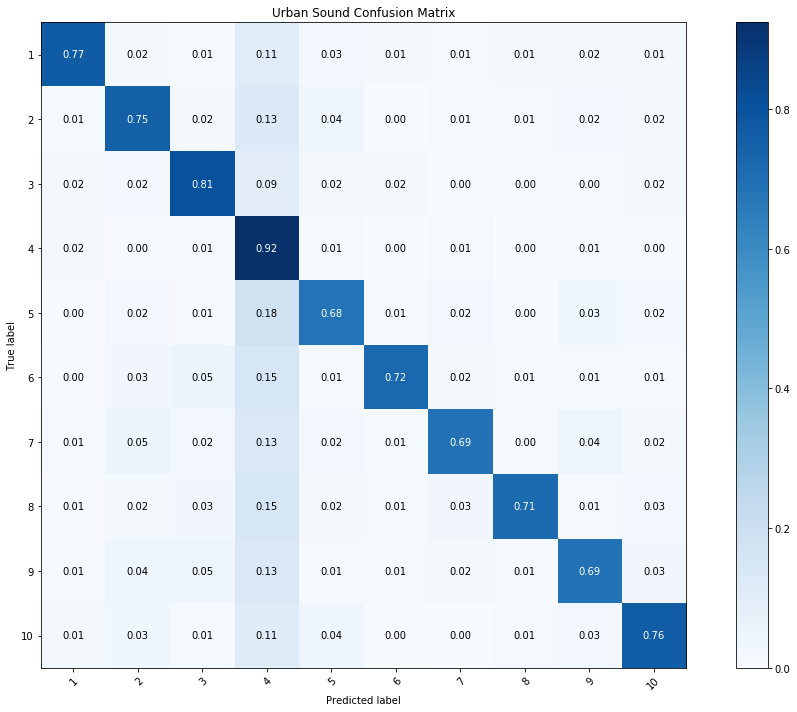

In [156]:
plot_confusion_matrix(y_test, y_test_pred, np.arange(1,11), normalize=True, title="Urban Sound Confusion Matrix")

# Problem 6

## Load Data

In [2]:
data_dir = os.path.join("..", "data")
data_train = np.loadtxt(os.path.join(data_dir, "svm-train.txt"))
data_test = np.loadtxt(os.path.join(data_dir, "svm-test.txt"))

x_train, y_train = data_train[:, 0:2], data_train[:, 2]
x_test, y_test = data_test[:, 0:2], data_test[:, 2]

In [3]:
# Change target to 0-1 label
y_train_label = np.array([1 if label > 0 else 0 for label in y_train])
y_test_label = np.array([1 if label > 0 else 0 for label in y_test])

## Decision Tree Boundary

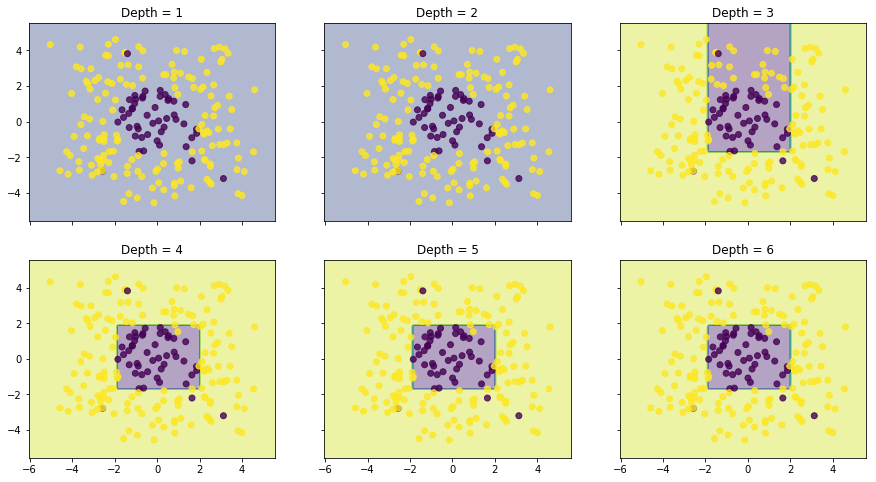

In [4]:
# Training classifiers with different depth
clf1 = ClassificationTree(max_depth=1)
clf1.fit(x_train, y_train_label)

clf2 = ClassificationTree(max_depth=2)
clf2.fit(x_train, y_train_label)

clf3 = ClassificationTree(max_depth=3)
clf3.fit(x_train, y_train_label)

clf4 = ClassificationTree(max_depth=4)
clf4.fit(x_train, y_train_label)

clf5 = ClassificationTree(max_depth=5)
clf5.fit(x_train, y_train_label)

clf6 = ClassificationTree(max_depth=6)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(15, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        [f"Depth = {n}" for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)
    curr_axis = axarr[idx[0], idx[1]]

    curr_axis.contourf(xx, yy, Z, alpha=0.4)
    curr_axis.scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    curr_axis.set_title(tt)

plt.show()

## Compare decision tree with tree model in sklearn

In [5]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_split=5)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file="tree_classifier.dot")

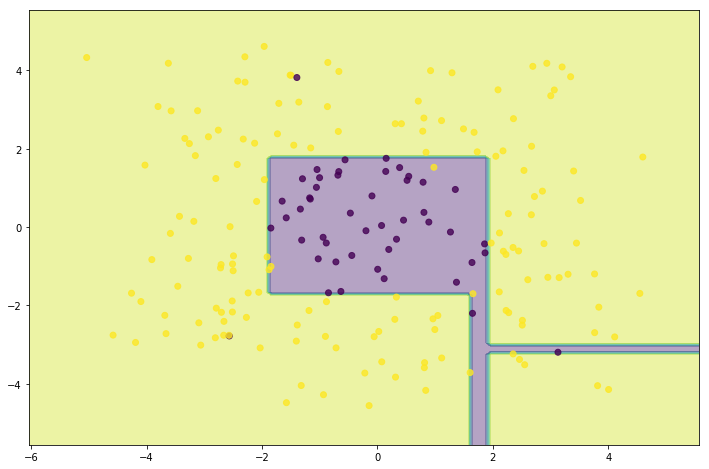

In [6]:
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
plt.show()
# curr_axis.set_title(tt)

In [28]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png

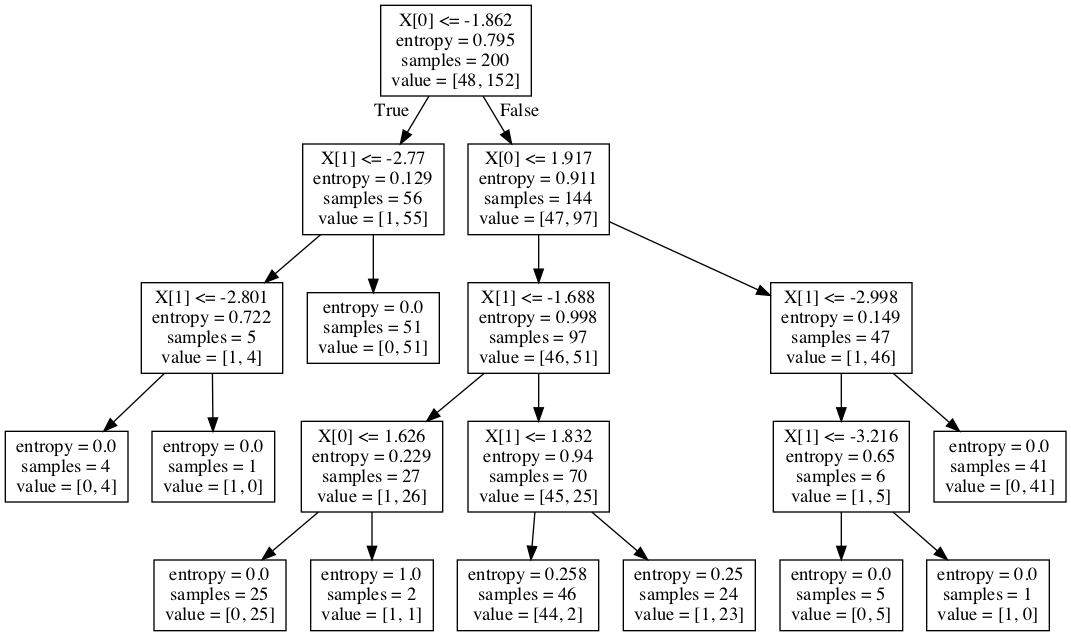

In [29]:
Image(filename="tree_classifier.png")

## Fit regression tree to one-dimensional regression data

/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chaaland/miniconda3/envs/BloombergML/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


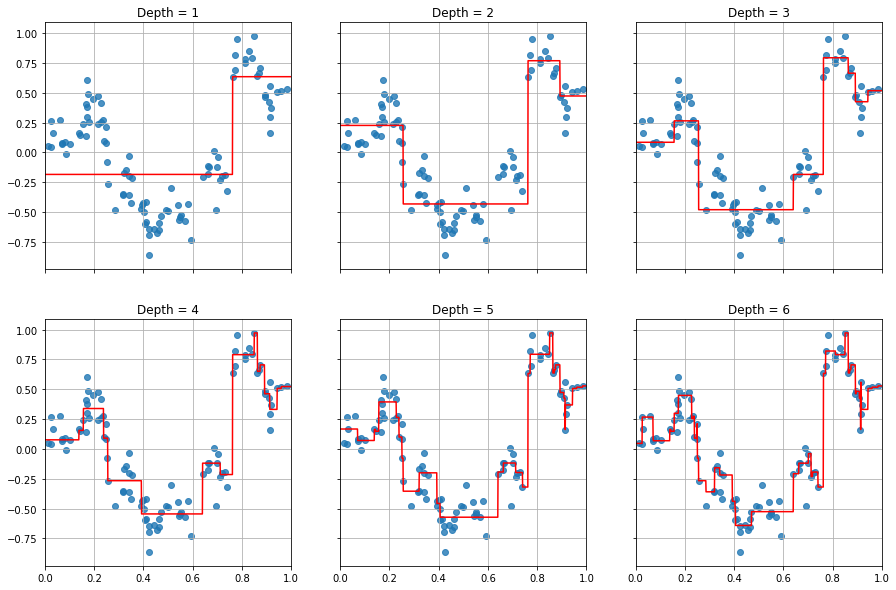

In [7]:
data_krr_train = np.loadtxt(os.path.join(data_dir, "krr-train.txt"))
data_krr_test = np.loadtxt(os.path.join(data_dir, "krr-test.txt"))

x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1), data_krr_train[:,1]
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1), data_krr_test[:,1]

# Training regression trees with different depth
clf1 = RegressionTree(max_depth=1,  min_sample=1, loss_function="mae", estimator="median")
clf1.fit(x_krr_train, y_krr_train)

clf2 = RegressionTree(max_depth=2,  min_sample=1, loss_function="mae", estimator="median")
clf2.fit(x_krr_train, y_krr_train)

clf3 = RegressionTree(max_depth=3,  min_sample=1, loss_function="mae", estimator="median")
clf3.fit(x_krr_train, y_krr_train)

clf4 = RegressionTree(max_depth=4,  min_sample=1, loss_function="mae", estimator="median")
clf4.fit(x_krr_train, y_krr_train)

clf5 = RegressionTree(max_depth=5,  min_sample=1, loss_function="mae", estimator="median")
clf5.fit(x_krr_train, y_krr_train)

clf6 = RegressionTree(max_depth=6,  min_sample=1, loss_function="mae", estimator="median")
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        [f"Depth = {n}" for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    curr_axis = axarr2[idx[0], idx[1]]

    curr_axis.plot(x_range, y_range_predict, color="r")
    curr_axis.scatter(x_krr_train, y_krr_train, alpha=0.8)
    curr_axis.set_title(tt)
    curr_axis.set_xlim(0, 1)
    curr_axis.grid(True)
plt.show()

# Problem 7

Consider the loss function given by $\ell(\hat{y}, y) = 1/2(\hat{y}-y)^2$. At the beginning of the $m$'th round of gradient boosting, we have the prediction function $f_{m-1}(x)$. To perform the next round of gradient boosting, we find the negative gradient of the loss function wrt each $f_{m-1}(x_i)$ which is given by $-(g_m)_i = -f_{m-1}(x_i) + y_i$.

We then solve the optimization problem 
$$\arg \min_{h\in \mathcal{F}} \sum_{i=1}^N ([y_i - f_{m-1}(x_i)] - h(x_i))^2$$
to fit a new function to the negative gradients of each example

In the classification case we have $\mathcal{Y} = \{-1,1\}$. Considering the logistic loss 
$$\ell(y, \hat{y}) = \log(1 + e^{-y\hat{y}})$$
Given the function $f_{m-1}(x)$ from $m-1$ iterations of gradient boosting we can find the gradient wrt each $f_{m-1}(x_i)$ which is given by $(g_m)_i = -y_i\frac{e^{-y_if_{m-1}(x_i)}}{1 + e^{-y_if_{m-1}(x_i)}} = -y_i\sigma(-y_if_{m-1}(x_i))$

Solving the optimization problem
$$h_m = \arg \min_{h\in \mathcal{F}} \sum_{i=1}^N\left(y_i\sigma(-y_if_{m-1}(x_i)) - h(x_i)\right)^2$$

gives the new function to add to $f_{m-1}(x)$

# Problem 8

## 2-D GBM visualization - SVM data

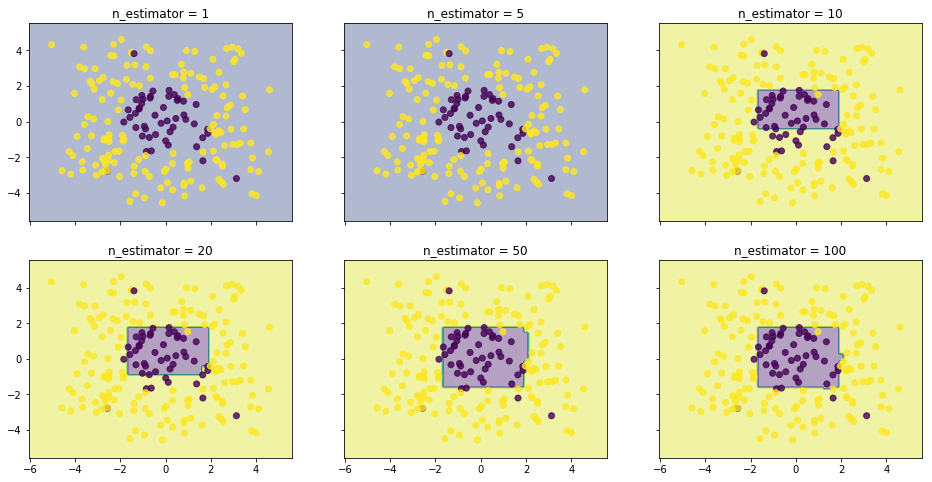

In [8]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(16, 8))

for idx, n in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100]):
    
    gbt = GradientBoosting(n_estimator=n, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbt.fit(x_train, y_train)
  
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    curr_axis = axarr[idx[0], idx[1]]

    curr_axis.contourf(xx, yy, Z, alpha=0.4)
    curr_axis.scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    curr_axis.set_title(f"n_estimator = {n}")


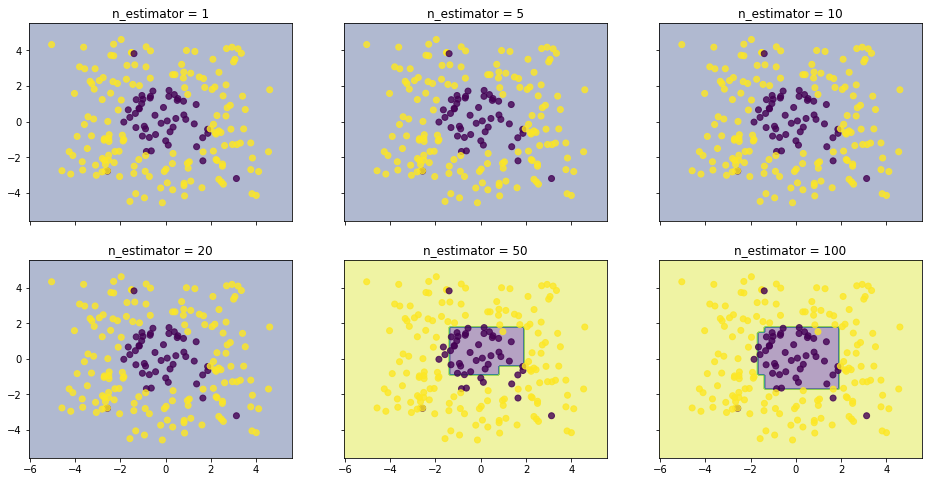

In [9]:
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(16, 8))

for idx, n in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100]):
    
    gbt = GradientBoosting(n_estimator=n, pseudo_residual_func=pseudo_residual_logistic, max_depth=2)  
    gbt.fit(x_train, 2*y_train_label-1)
#     gbt.fit(x_train, y_train)

    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    curr_axis = axarr[idx[0], idx[1]]
    curr_axis.contourf(xx, yy, Z, alpha=0.4)
    curr_axis.scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    curr_axis.set_title(f"n_estimator = {n}")


## 1-D GBM visualization - KRR data

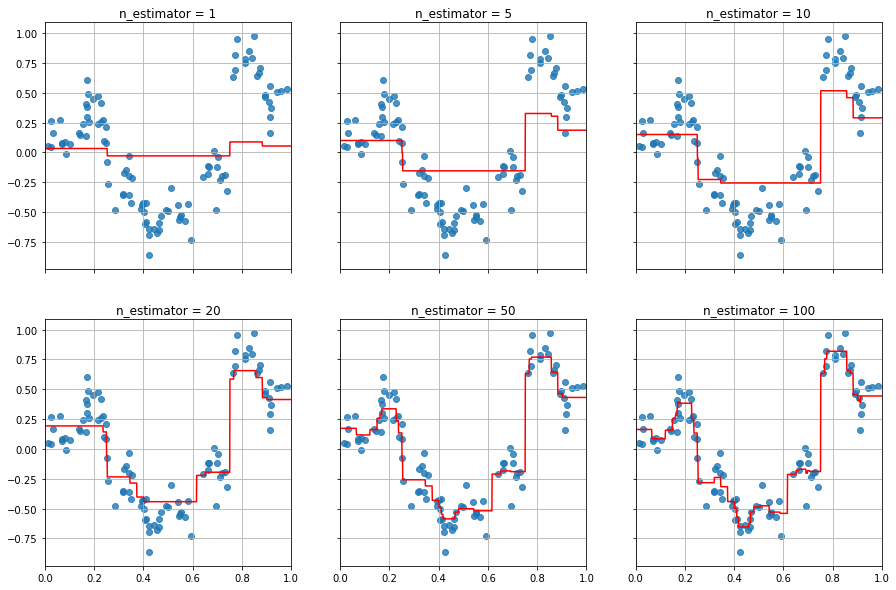

In [10]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(15, 10))

for idx, n in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100]):
    
    gbm_1d = GradientBoosting(n_estimator=n, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gbm_1d.predict(x_range)
    curr_axis = axarr2[idx[0], idx[1]]

    curr_axis.plot(x_range, y_range_predict, color="r")
    curr_axis.scatter(x_krr_train, y_krr_train, alpha=0.8)
    curr_axis.set_title(f"n_estimator = {n}")
    curr_axis.set_xlim(0, 1)
    curr_axis.grid(True)

# Compare with _sklearn_ GradientBoosting

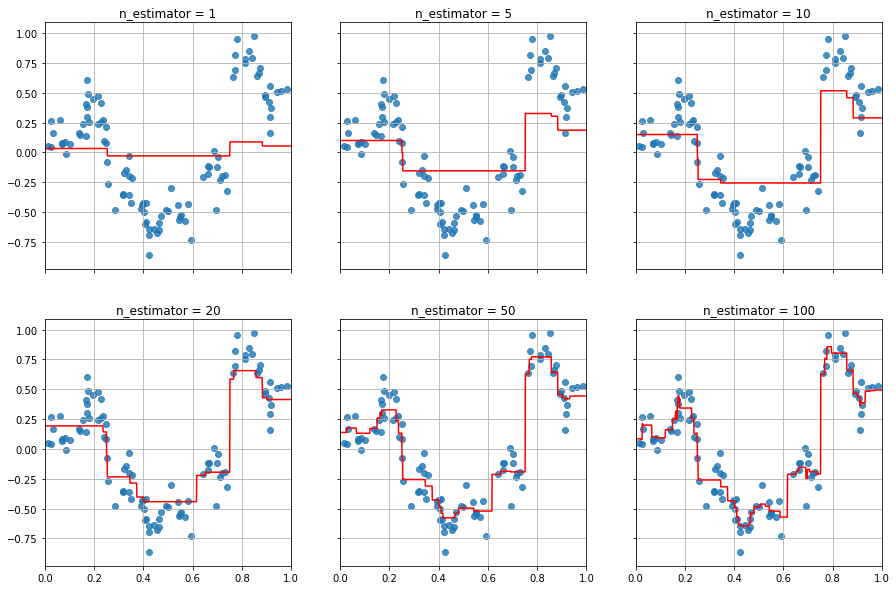

In [11]:
from sklearn import ensemble
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(15, 10))

for idx, n in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100]):
    params = {
        "n_estimators": n,
        "max_depth": 2,
        "learning_rate": 0.1,
        "criterion": "mse",
    }

    gradient_boosting_regressor = ensemble.GradientBoostingRegressor(**params)
    gradient_boosting_regressor.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gradient_boosting_regressor.predict(x_range)
    curr_axis = axarr2[idx[0], idx[1]]

    curr_axis.plot(x_range, y_range_predict, color="r")
    curr_axis.scatter(x_krr_train, y_krr_train, alpha=0.8)
    curr_axis.set_title(f"n_estimator = {n}")
    curr_axis.set_xlim(0, 1)
    curr_axis.grid(True)